<a href="https://colab.research.google.com/github/slavam/Delphi_erc/blob/master/fastai_max_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.4 MB/s eta 0:00:00


In [2]:
#hide
# from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
# step 2
df = pd.read_csv('/content/donetsk_16_21_with_max_temp.csv', sep=';', header=0)
df.pop('date')
df.pop('term')
df.pop('visibility_range')

date_time = pd.to_datetime(df.pop('started_at'), format='%Y-%m-%d %H:%M:%S')
df.head()

,cloud_height,cloud_amount,wind_direction,wind_speed,...,pressure,pressure_tendency,pressure_tendency_value,max_day_temp
0,9,4,5,2,...,999.7,7,0.5,-11.5
1,9,4,5,2,...,1000.1,3,0.4,-11.5
2,9,6,5,2,...,1000.7,2,0.6,-11.5
3,5,5,5,2,...,1000.9,2,0.2,-11.5
4,9,6,5,2,...,1000.8,8,0.1,-11.5


In [ ]:
dep_var = 'max_day_temp'

In [ ]:
wv = df.pop('wind_speed')

# Convert to radians.
wd_rad = df.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:

train_dataset = df.sample(frac=0.8, random_state=0)
valid_dataset = df.drop(train_dataset.index)
splits = (list(train_dataset.index),list(valid_dataset.index))
cat = ['cloud_height','cloud_amount','pressure_tendency']
cont = [
 'temperature',
 'temperature_dew',
 'pressure',
 'pressure_tendency_value',
 'Wx',
 'Wy',
 'day_sin',
 'day_cos',
 'year_sin',
 'year_cos']

In [ ]:
procs = [Categorify, FillMissing]
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(12982, 3246)

In [ ]:
to.show(3)

,cloud_height,cloud_amount,pressure_tendency,temperature,temperature_dew,pressure,pressure_tendency_value,Wx,Wy,day_sin,day_cos,year_sin,year_cos,max_day_temp
10832,9,0,7,24.200001,0.4,988.599976,2.5,5.346039,2.723943,7.079376e-12,-1.000000,-0.965497,-0.260413,24.5
16071,6,3,8,29.600000,16.1,986.200012,0.4,1.782013,0.907981,7.071068e-01,-0.707107,-0.006645,-0.999978,32.0
2244,9,6,8,11.800000,9.4,994.400024,0.7,0.000000,0.000000,-7.071068e-01,0.707107,-0.993190,0.116509,21.5


In [ ]:
to.items.head(3)

,cloud_height,cloud_amount,temperature,temperature_dew,...,day_sin,day_cos,year_sin,year_cos
10832,6,1,24.200001,0.4,...,7.079376e-12,-1.000000,-0.965497,-0.260413
16071,5,4,29.600000,16.1,...,7.071068e-01,-0.707107,-0.006645,-0.999978
2244,6,7,11.800000,9.4,...,-7.071068e-01,0.707107,-0.993190,0.116509


In [ ]:
save_pickle('to.pkl',to)

In [ ]:
to = load_pickle('to.pkl')

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [ ]:
! [ -e /content ] && pip install -Uqq waterfallcharts treeinterpreter dtreeviz

  Preparing metadata (setup.py) ... done


In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, valid_xs, valid_y)

2.568113

In [ ]:
m.get_n_leaves(), len(xs)

(10225, 12982)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(1.844749, 2.145423)

In [ ]:
m.get_n_leaves()

394

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(1.36943, 1.830534)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
r_mse(preds.mean(0), valid_y)

1.830962

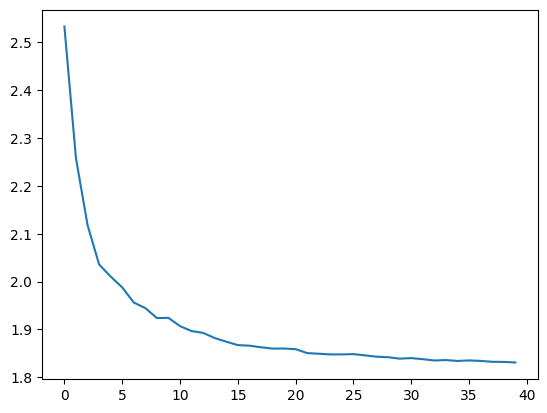

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

In [ ]:
r_mse(m.oob_prediction_, y)

1.846208

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(40, 3246)

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([2.02513289, 0.89087264, 1.66117469, 1.44407788, 1.16252628])

Text(0, 0.5, 'Prediction Confidence / Standard Deviation')

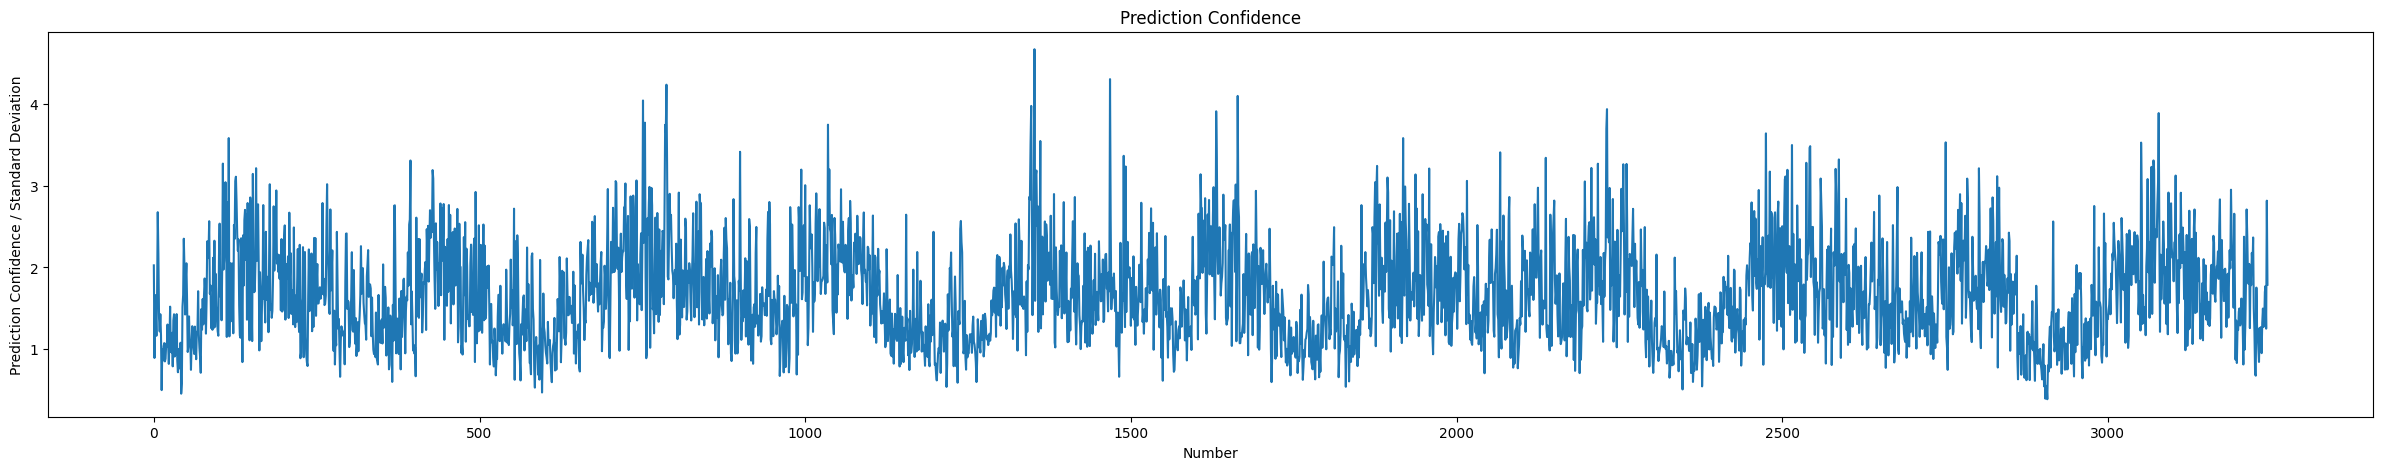

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(range(len(preds_std)),preds_std)
plt.title("Prediction Confidence")
plt.xlabel("Number")
plt.ylabel("Prediction Confidence / Standard Deviation")

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
3,temperature,0.545577
12,year_cos,0.263436
4,temperature_dew,0.090977
11,year_sin,0.027931
0,cloud_height,0.022959
1,cloud_amount,0.018133
10,day_cos,0.010833
5,pressure,0.009933
8,Wy,0.003856
7,Wx,0.002232


<Axes: ylabel='cols'>

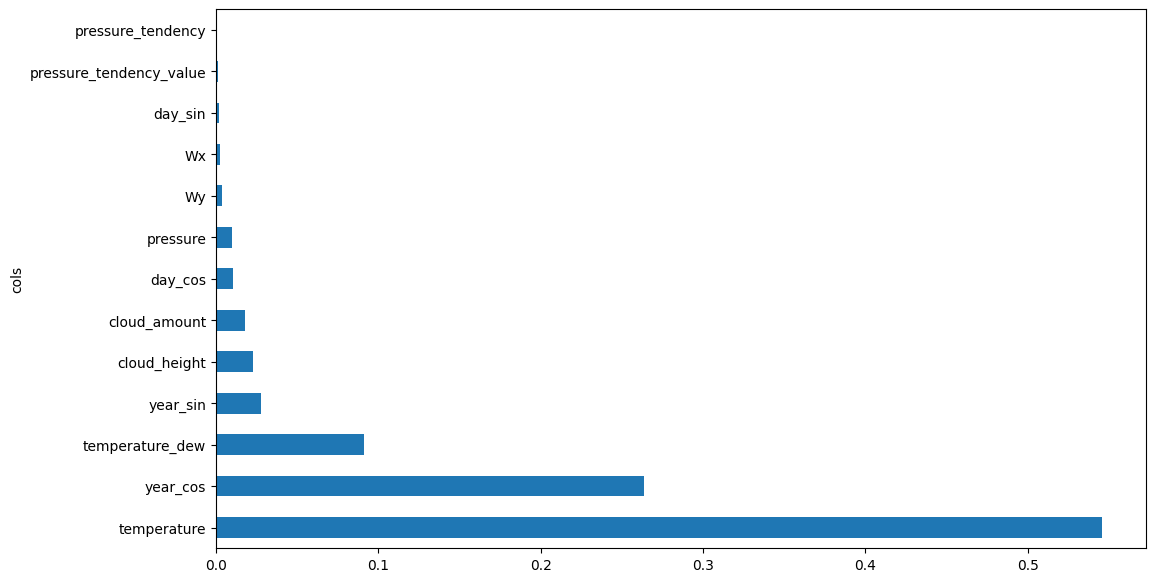

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)
to_keep

3         temperature
12           year_cos
4     temperature_dew
11           year_sin
0        cloud_height
1        cloud_amount
10            day_cos
5            pressure
Name: cols, dtype: object

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(1.475632, 1.915102)

In [ ]:
len(xs.columns), len(xs_imp.columns)

(13, 8)

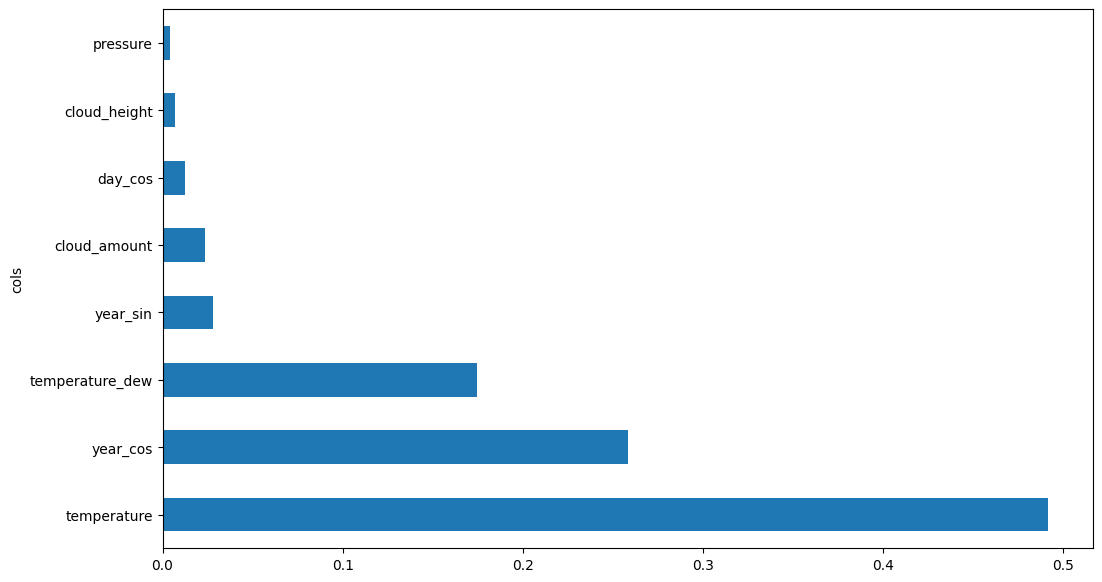

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

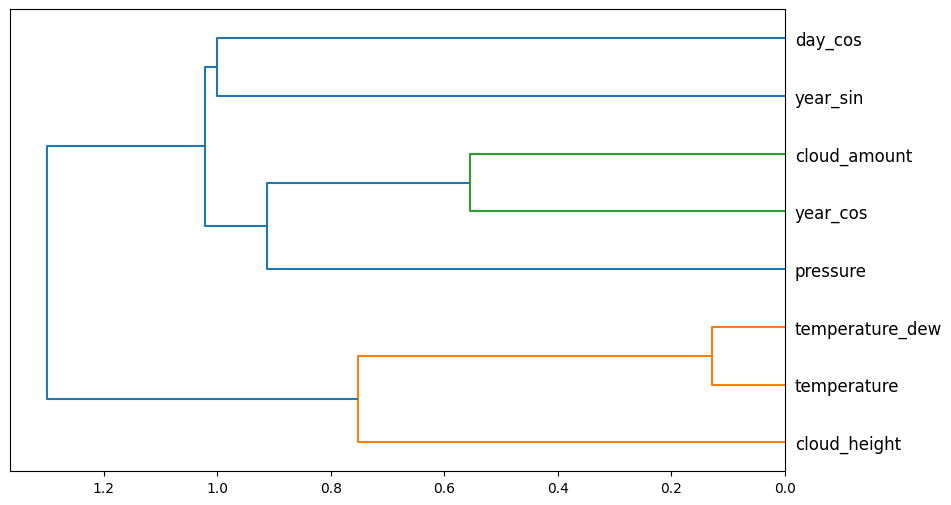

In [ ]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    # Ripped from fastai/book_nbs/utils.py https://github.com/fastai/book_nbs/blob/a7548b8d7f81cc04d0a2d035d05497c6833048c1/utils.py
    from scipy.cluster import hierarchy as hc
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
    tree = RandomForestRegressor(n_estimators=40,
                                min_samples_leaf=15,
                                max_samples=7_000,
                                 max_features=0.5,
                                 n_jobs=-1,
                                 oob_score=True)
    tree.fit(df, y)
    return tree.oob_score_

In [ ]:
get_oob(xs_imp)

0.9722021402190473

In [ ]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [ ]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)

In [ ]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(1.470556, 1.905222)

([<matplotlib.axis.YTick at 0x7d2ee3843d60>,
 [Text(0, 0, '#na#'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6'),
  Text(0, 6, '9'),
  Text(0, 7, '10')])

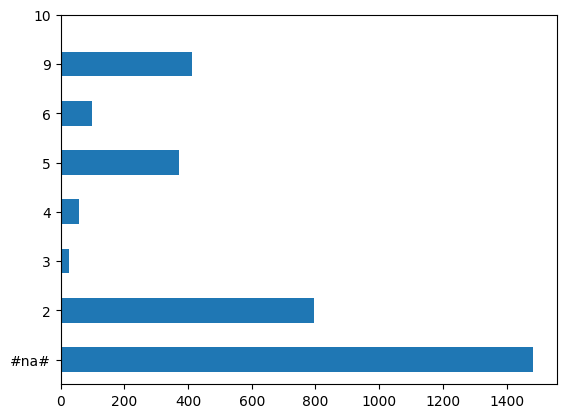

In [ ]:
p = valid_xs_final['cloud_height'].value_counts(sort=False).plot.barh()
c = to.classes['cloud_height']
plt.yticks(range(len(c)), c)

([<matplotlib.axis.YTick at 0x7d2ee3671ff0>,
 [Text(0, 0, '#na#'),
  Text(0, 1, '0'),
  Text(0, 2, '1'),
  Text(0, 3, '2'),
  Text(0, 4, '3'),
  Text(0, 5, '4'),
  Text(0, 6, '5'),
  Text(0, 7, '6'),
  Text(0, 8, '7'),
  Text(0, 9, '8'),
  Text(0, 10, '9')])

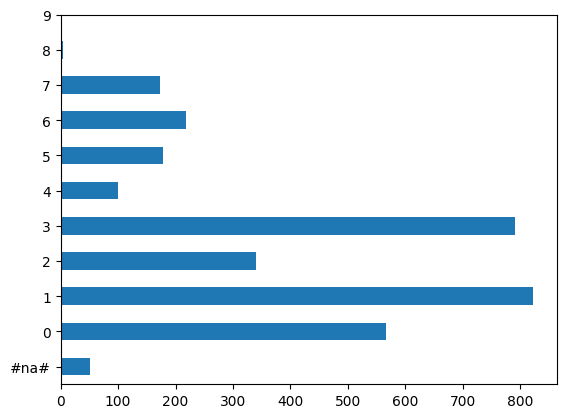

In [ ]:
p = valid_xs_final['cloud_amount'].value_counts(sort=False).plot.barh()
c = to.classes['cloud_amount']
plt.yticks(range(len(c)), c)

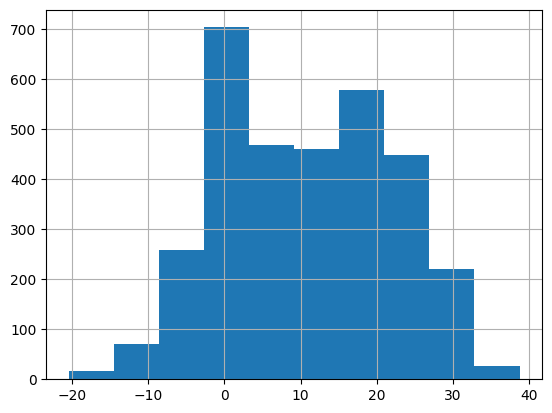

In [ ]:
ax = valid_xs_final['temperature'].hist()

In [ ]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=cfa5be9aebfd3bbccd38eeb12b14992a6314b316c86698ba5fa350fe57fb057b
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn


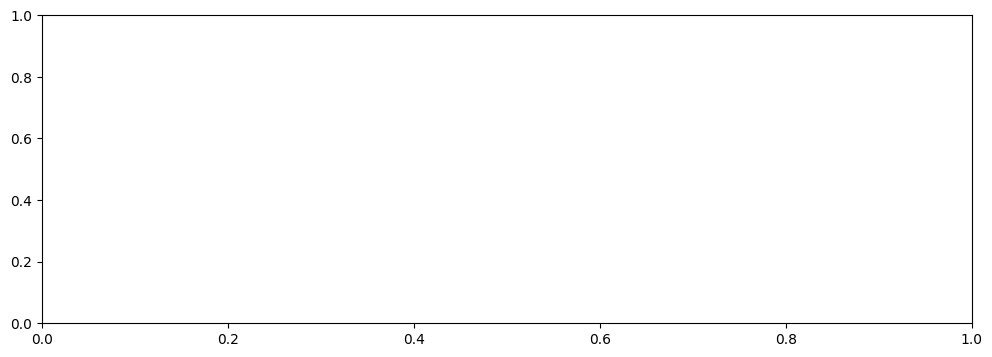

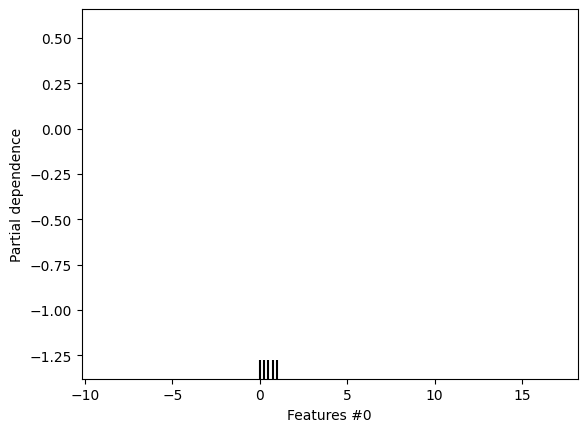

In [ ]:
# from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
fig,ax = plt.subplots(figsize=(12, 4))
pd_results = partial_dependence(m, valid_xs_final, features=2, kind="average", grid_resolution=20)
features, feature_names = [(0,)], [f"Features #{i}" for i in range(valid_xs_final.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}
display = PartialDependenceDisplay([pd_results],features=features,feature_names=feature_names,target_idx=0, deciles=deciles)
display.plot(pdp_lim={1: (-1.38, 0.66)})
plt.show()

In [ ]:
!pip install treeinterpreter
!pip install waterfallcharts

In [ ]:
from waterfall_chart import plot as waterfall
from treeinterpreter import treeinterpreter

In [ ]:
row = valid_xs_final[:5]
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([-11.45163203]), 14.903655261863303, -26.35528729469722)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

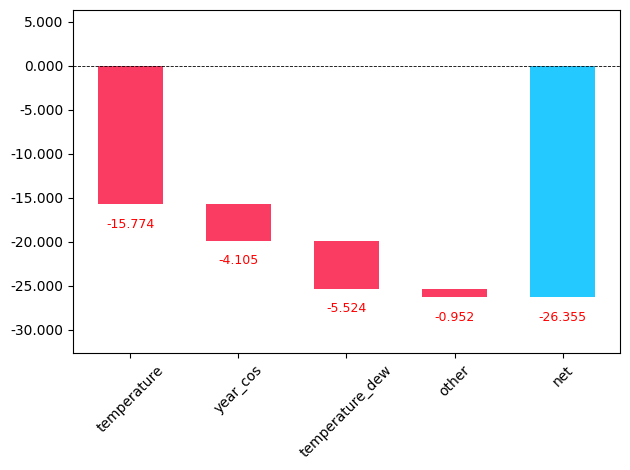

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}')

In [ ]:
valid_xs_final.head()

,temperature,year_cos,temperature_dew,year_sin,cloud_height,cloud_amount,day_cos,pressure
0,-14.3,0.999996,-15.600000,-0.002666,6,5,1.000000e+00,999.700012
13,-14.6,0.999680,-16.600000,0.025285,6,7,-7.071068e-01,1002.400024
21,-17.4,0.999097,-19.299999,0.042478,6,1,-7.071068e-01,997.500000
25,-20.4,0.998695,-21.600000,0.051070,6,1,7.071068e-01,994.200012
26,-20.4,0.998583,-21.000000,0.053217,6,1,5.627534e-12,993.700012


In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
7,pressure,0.180737
1,year_cos,0.179555
3,year_sin,0.173528
2,temperature_dew,0.170713
0,temperature,0.169563
5,cloud_amount,0.049462
6,day_cos,0.045187
4,cloud_height,0.031254


In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('year_sin','pressure','year_cos','temperature_dew','temperature'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 1.906607
year_sin 1.986491
pressure 1.956679
year_cos 1.999901
temperature_dew 1.927382
temperature 2.535898


In [ ]:
time_vars = ['temperature_dew','pressure']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

1.948038

In [ ]:
m = rf(xs_final, y)
m_rmse(m, valid_xs_final, valid_y)

1.898051

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(1.47241, 1.904742)

# Новый раздел

In [9]:
df_nn = pd.read_csv('/content/donetsk_16_21_with_max_temp.csv', sep=';', header=0)
df_nn.pop('date')
df_nn.pop('term')
df_nn.pop('visibility_range')

date_time = pd.to_datetime(df_nn.pop('started_at'), format='%Y-%m-%d %H:%M:%S')
df_nn.head()

,cloud_height,cloud_amount,wind_direction,wind_speed,...,pressure,pressure_tendency,pressure_tendency_value,max_day_temp
0,9,4,5,2,...,999.7,7,0.5,-11.5
1,9,4,5,2,...,1000.1,3,0.4,-11.5
2,9,6,5,2,...,1000.7,2,0.6,-11.5
3,5,5,5,2,...,1000.9,2,0.2,-11.5
4,9,6,5,2,...,1000.8,8,0.1,-11.5


In [6]:
dep_var = 'max_day_temp'

In [10]:
wv = df_nn.pop('wind_speed')

# Convert to radians.
wd_rad = df_nn.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
df_nn['Wx'] = wv*np.cos(wd_rad)
df_nn['Wy'] = wv*np.sin(wd_rad)

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df_nn['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_nn['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_nn['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_nn['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [12]:
df_nn.head()

,cloud_height,cloud_amount,temperature,temperature_dew,...,day_sin,day_cos,year_sin,year_cos
0,9,4,-14.3,-15.6,...,-1.407890e-12,1.000000e+00,-0.002666,0.999996
1,9,4,-15.0,-16.3,...,7.071068e-01,7.071068e-01,-0.000516,1.000000
2,9,6,-15.4,-17.3,...,1.000000e+00,3.971235e-12,0.001634,0.999999
3,5,5,-12.7,-14.7,...,7.071068e-01,-7.071068e-01,0.003785,0.999993
4,9,6,-11.7,-15.2,...,6.534579e-12,-1.000000e+00,0.005935,0.999982


In [13]:
continous_nn, categorical_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [16]:
df_nn[categorical_nn].nunique()

cloud_height          7
cloud_amount         10
pressure_tendency     9
dtype: int64

In [17]:
train_dataset = df_nn.sample(frac=0.8, random_state=0)
valid_dataset = df_nn.drop(train_dataset.index)
splits = (list(train_dataset.index),list(valid_dataset.index))

In [66]:
df_nn['Wx'][0]

1.992389396183491

In [18]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df=df_nn,
                     procs=procs_nn,
                     cat_names=categorical_nn,
                     cont_names=continous_nn,
                     splits=splits,
                     y_names=dep_var)

dls = to_nn.dataloaders(1024)

y = to_nn.train.y
y.min(),y.max()

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'


(-15.8, 40.0)

In [51]:
learn = tabular_learner(dls, y_range=(-16,42), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch	train_loss	valid_loss	time

0	368.884644	365.149445	00:01

1	369.040802	366.604828	00:01

2	369.286469	367.506165	00:00

3	369.599945	367.792908	00:00

4	369.651733	367.709503	00:00

In [54]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [55]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'


1.963656

In [86]:
def prepare_data(date_term, telegram): #, model_name):
  ret = pd.DataFrame({
    'cloud_height': [],
    'cloud_amount': [],
    'temperature':[],
    'temperature_dew':[],
    'pressure':[],
    'pressure_tendency':[],
    'pressure_tendency_value':[],
    'Wx':[],
    'Wy':[],
    'day_sin':[],
    'day_cos':[],
    'year_sin':[],
    'year_cos':[],
  })
  # ret.append(float(telegram[14:15]+'.')) # cloud_height
  ret.at[0, 'cloud_height'] = int(telegram[14:15]) #ret.append(int(telegram[14:15])) # cloud_height
  ret.at[0, 'cloud_amount'] =int(telegram[18:19]) #ret.append(int(telegram[18:19])) # cloud_amount
  sign = ''
  if telegram[25:26] == '1':
    sign = '-'
  ret.at[0, 'temperature']=float(sign+telegram[26:28]+'.'+telegram[28:29]) #ret.append(float(sign+telegram[26:28]+'.'+telegram[28:29]))# temperature
  sign = ''
  if telegram[31:32] == '1':
    sign = '-'
  ret.at[0, 'temperature_dew']=float(sign+telegram[32:34]+'.'+telegram[34:35]) #ret.append(float(sign+telegram[32:34]+'.'+telegram[34:35]))# temperature_dew
  p1 = '1'
  if telegram[37:38] != '0':
    p1 = ''
  ret.at[0, 'pressure']=float(p1+telegram[37:40]+'.'+telegram[40:41]) #ret.append(float(p1+telegram[37:40]+'.'+telegram[40:41]))# pressure
  ret.at[0, 'pressure_tendency']=float(telegram[49:50]+'.') #ret.append(float(telegram[49:50]+'.'))#  pressure_tendency
  ret.at[0, 'pressure_tendency_value']=float(telegram[50:52]+'.'+telegram[52:53]) #ret.append(float(telegram[50:52]+'.'+telegram[52:53]))# pressure_tendency_value
  wv = float(telegram[21:23]+'.')
  wd_rad = int(telegram[19:21])*10*np.pi/180
  ret.at[0, 'Wx']=wv*np.cos(wd_rad) #ret.append(wv*np.cos(wd_rad)) # Wx
  ret.at[0, 'Wy']=wv*np.sin(wd_rad) #ret.append(wv*np.sin(wd_rad)) # Wy
  d = datetime.strptime(date_term, "%Y-%m-%d %H:%M:%S")
  s = time.mktime(d.timetuple())
  day = 24*60*60
  year = (365.2425)*day
  ret.at[0, 'day_sin']=np.sin(s * (2 * np.pi / day)) #ret.append(np.sin(s * (2 * np.pi / day)))
  ret.at[0, 'day_cos']=np.cos(s * (2 * np.pi / day)) #ret.append(np.cos(s * (2 * np.pi / day)))
  ret.at[0, 'year_sin']=np.sin(s * (2 * np.pi / year)) #ret.append(np.sin(s * (2 * np.pi / year)))
  ret.at[0, 'year_cos']=np.cos(s * (2 * np.pi / year)) #ret.append(np.cos(s * (2 * np.pi / year))) #Day sin 	Day cos 	Year sin 	Year cos
  telegram = [ret]
  dl = learn.dls.test_dl(ret)

  # model = tf.keras.models.load_model(model_name)
  # predict_temperature = learn.predict(telegram).flatten()[0]
  predict_temperature = learn.get_preds(dl=dl)

  return predict_temperature

d_t = '2023-10-27 06:00:00'
telegram = '27061 34519 11093 91802 10127 20127 39795 40033 57010 60022 74584 333 20109 555 53002='
max_temperature = prepare_data(d_t, telegram)
max_temperature

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'


(tensor([[16.8550]]), None)

In [56]:
dl = learn.dls.test_dl(train_dataset)

In [ ]:
predict_temperature = learn.get_preds(dl=dl)

In [58]:
predict_temperature

(tensor([[25.1445],
         [32.2929],
         [19.0329],
         ...,
         [ 7.0471],
         [10.7497],
         [-0.3203]]),
 tensor([[24.5000],
         [32.0000],
         [21.5000],
         ...,
         [ 8.8000],
         [11.0000],
         [ 0.1000]]))

In [84]:
# 01234567890123456789
# 27091 34519 41495 82304 10154 20130 39795 40031 54000 71042 886//=
data = pd.DataFrame({
    'cloud_height': [4],
    'cloud_amount': [8],
    'temperature':[15.4],
    'temperature_dew':[13.],
    'pressure':[],'pressure_tendency','pressure_tendency_value','Wx	Wy	day_sin	day_cos	year_sin	year_cos'],
})
data

,cloud_height,cloud_amount
0,4,8


In [80]:
data

10832    5.346039
16071    1.782013
2244     0.000000
461      1.696096
3051     1.618034
           ...   
4614     3.392192
4054     3.564026
8274     5.889763
15398    1.618034
12013    5.638156
Name: Wx, Length: 12982, dtype: float64